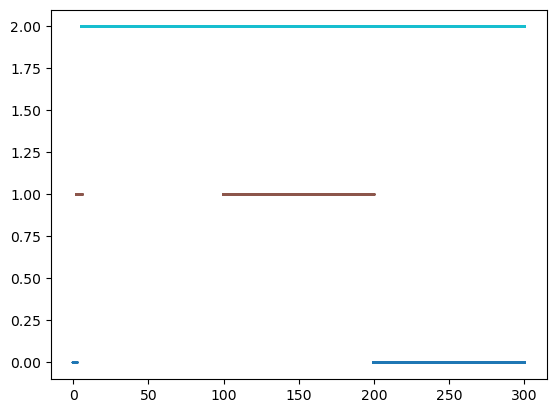

In [1]:
# simulate data
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# np.random.seed(42)


def generate_non_stationary_sequence(
    n_time: int = 50_000, sampling_frequency: float = 500.0
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    n_states = 3

    model1 = hmm.PoissonHMM(n_components=n_states)

    model1.startprob_ = np.array([1.0, 0.00, 0.00])

    model1.transmat_ = np.array(
        [[0.999, 0.001, 0.000],
         [0.000, 0.999, 0.001],
         [0.000, 0.000, 1.00]]
    )

    model1.lambdas_ = np.array([10.0, 20.0, 30.0])[:, np.newaxis] / sampling_frequency

    spikes1, state_sequence1 = model1.sample(n_time)

    model2 = hmm.PoissonHMM(n_components=n_states)

    model2.startprob_ = np.array([0.00, 0.000, 1.00])

    model2.transmat_ = np.array(
        [[0.0000, 0.0000, 1.000],
         [0.000,  0.95,  0.05],
         [0.0000, 0.05, 0.95]]
    )

    model2.lambdas_ = model1.lambdas_

    spikes2, state_sequence2 = model2.sample(n_time)
    
    model3 = hmm.PoissonHMM(n_components=n_states)

    model3.startprob_ = np.array([0.00, 0.00, 1.00])
    
    model3.transmat_ = np.array(
        [[0.80, 0.0000, 0.200],
         [0.5,  0.0,  0.5],
         [0.20, 0.00, 0.80]]
    )

    model3.lambdas_ = model1.lambdas_

    spikes3, state_sequence3 = model3.sample(n_time)


    spikes = np.concatenate([spikes1, spikes2, spikes3]).squeeze()
    state_sequence = np.concatenate([state_sequence1, state_sequence2, state_sequence3])
    
    time = np.arange(len(state_sequence)) / sampling_frequency

    return time, spikes, state_sequence, model1, model2, model3


time, spikes, state_sequence, model1, model2, model3 = generate_non_stationary_sequence()

plt.scatter(time, state_sequence, c=state_sequence, s=1, cmap="tab10")


In [2]:
from patsy import dmatrix


n_states = model1.n_components

data = {
    "time": time,
}

formula = "1 + bs(time, df=3)"

transition_design_matrix = dmatrix(formula, data)
n_coefficients = transition_design_matrix.shape[1]

transition_coefficients = np.ones(((n_coefficients, n_states, (n_states - 1))))
transition_coefficients.shape


(4, 3, 2)

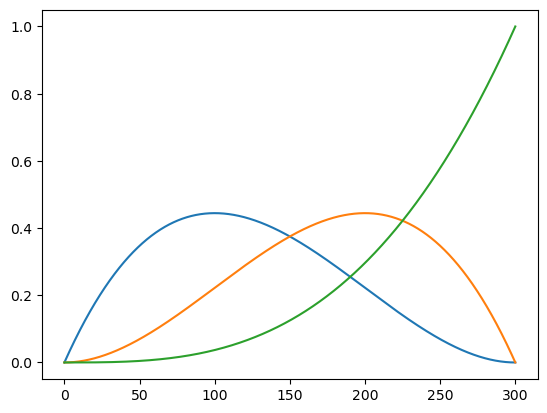

In [3]:
plt.plot(time, transition_design_matrix[:, 1:])


In [4]:
from src.estimate_transition import (
    estimate_non_stationary_state_transition, jax_centered_log_softmax_forward
)
from src.hmm import forward, smoother, check_converged
import scipy.stats

tolerance = 1e-4
max_iter = 200

data_log_likelihoods = []
n_iter = 0
converged = False


initial_conditions = model1.startprob_
local_rates = model1.lambdas_.T
log_likelihood = scipy.stats.poisson.logpmf(spikes[:, np.newaxis], local_rates)
# transition_matrix = model1.transmat_[np.newaxis] * np.ones((spikes.shape[0], 1, 1))
transition_coefficients = np.zeros(((n_coefficients, n_states, (n_states - 1))))

transition_matrix = np.zeros((spikes.shape[0], n_states, n_states))

for from_state in range(n_states):
    transition_matrix[:, from_state, :] = np.exp(
        jax_centered_log_softmax_forward(
            transition_design_matrix @ transition_coefficients[:, from_state, :]))

# transition_coefficients[0, :, :] = np.log(transition_matrix[0, :, :-1])

while not converged and (n_iter < max_iter):
    # Expectation
    causal_posterior, predictive_distribution, marginal_likelihood = forward(
        initial_conditions, log_likelihood, transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, transition_matrix
    )
    # Maximization
    (
        transition_coefficients,
        transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        transition_matrix,
        acausal_posterior,
    )
    transition_matrix = transition_matrix / transition_matrix.sum(axis=-1, keepdims=True)
    
    # Stats
    n_iter += 1

    data_log_likelihoods.append(marginal_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")

iteration 1, likelihood: -29369.306399552137
iteration 2, likelihood: -29366.52939159087, change: 2.7770079612673726


(0.0, 1.0)

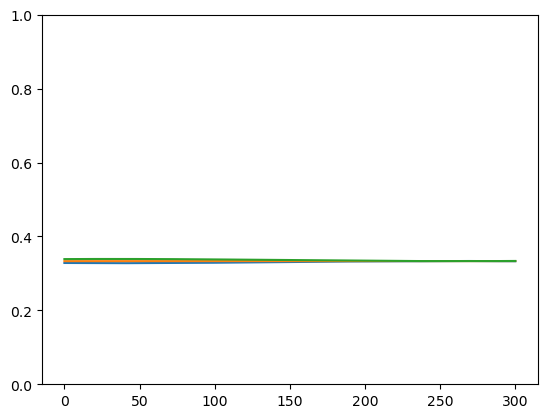

In [5]:
for i in range(n_states):
    plt.plot(time, transition_matrix[:, i, i])
    
plt.ylim(0, 1)

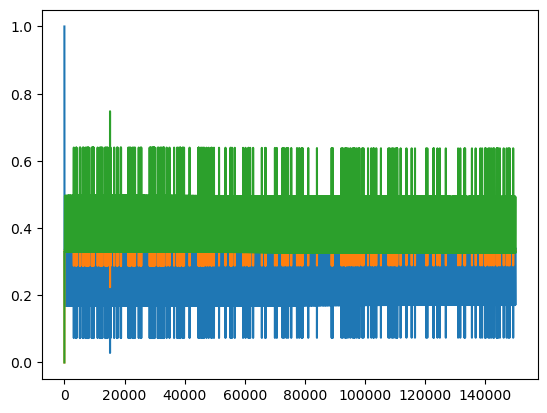

In [6]:
plt.plot(acausal_posterior)